# Phase 4 project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import nltk
from nltk import pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

%matplotlib inline

In [3]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [4]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Change the column names so it can be more readable

data.columns = ['tweet', 'product', 'sentiment']

In [6]:
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
df = data[(data['sentiment'] == "Negative emotion") | (data['sentiment'] == "Positive emotion")]

In [9]:
df = data.dropna(axis=0)

In [10]:
df

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [11]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [12]:
df.isnull().sum()

tweet        0
product      0
sentiment    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3291 non-null   object
 1   product    3291 non-null   object
 2   sentiment  3291 non-null   object
dtypes: object(3)
memory usage: 102.8+ KB


Pre-processing

In [14]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [15]:
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
df

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [127]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
lemmatizer = nltk.stem.WordNetLemmatizer()
sw = set(stopwords.words('english'))
sw.update(['link', 'rt', 'quot', 'amp'])

df['tweet_edited'] = df['tweet']
df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
df['tweet_edited'] = df['tweet_edited'].apply(str.split)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x if '@' not in n]))
df['tweet_edited'] = df['tweet_edited'].apply(tokenizer.tokenize)
df['tweet_edited'] = df['tweet_edited'].apply(pos_tag)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: [(n[0], get_wordnet_pos(n[1])) for n in x])
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([lemmatizer.lemmatize(n[0], (n[1])) for n in x]))
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

df['product'] = df['product'].apply(str.strip)
df['Company'] = df['product']
df['Company'] = df['Company'].replace({
    'iPad':'Apple',
    'iPad or iPhone App':'Apple',
    'iPhone':'Apple',
    'Other Apple product or service':'Apple',
    'Other Google product or service':'Google',
    'Android App':'Google',
    'Android':'Google'   
})
df


<ipython-input-127-90c1795ea903>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet']
<ipython-input-127-90c1795ea903>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
<ipython-input-127-90c1795ea903>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,tweet,product,sentiment,tweet_edited,Company
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,g iphone hr tweeting rise austin dead need upgrade plugin station sxsw,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate design also they're give free sxsw,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,wait ipad also sale sxsw,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app sxsw,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,great stuff fri sxsw marissa mayer google tim o'reilly tech book conference matt mullenweg wordp...,Google
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,iPhone,Positive emotion,pr guy convince switch back iphone great sxsw coverage princess,Apple
9079,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,iPad,Positive emotion,papyrus sort like ipad nice lol sxsw lavelle,Apple
9080,"Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essenti...",Other Google product or service,Negative emotion,diller say google tv might run playstation xbox essentially ready today sxsw diller,Google
9085,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an i...,iPad or iPhone App,Positive emotion,i've always use camera iphone b c image stabilizer mode suggestion ipad cam app w feature sxsw s...,Apple


In [128]:
df

,tweet,product,sentiment,tweet_edited,Company
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upg...",iPhone,Negative emotion,g iphone hr tweeting rise austin dead need upgrade plugin station sxsw,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate design also they're give free sxsw,Apple
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,wait ipad also sale sxsw,Apple
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app sxsw,Apple
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conference...",Google,Positive emotion,great stuff fri sxsw marissa mayer google tim o'reilly tech book conference matt mullenweg wordp...,Google
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,iPhone,Positive emotion,pr guy convince switch back iphone great sxsw coverage princess,Apple
9079,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,iPad,Positive emotion,papyrus sort like ipad nice lol sxsw lavelle,Apple
9080,"Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essenti...",Other Google product or service,Negative emotion,diller say google tv might run playstation xbox essentially ready today sxsw diller,Google
9085,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an i...,iPad or iPhone App,Positive emotion,i've always use camera iphone b c image stabilizer mode suggestion ipad cam app w feature sxsw s...,Apple


In [129]:
pd.options.display.max_colwidth = 100

In [130]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Positive emotion')]
df_subset['tweet'][0:50]

1      @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its de...
2                          @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
8      Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad ap...
9                 Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear
14                                       Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l
15                      haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw
18     Just added my #SXSW flights to @planely. Matching people on planes/airports. Also downloaded the...
19     Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram...
20     Need to buy an iPad2 while I'm in Austin at #sxsw. Not sure if I'll need to Q up at an Austin Ap...
21     Oh. My. God. The #SXSW app for

<ipython-input-168-f94dd10cf2e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


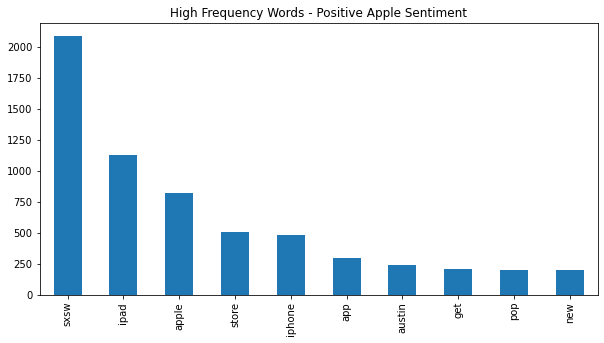

In [168]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Positive emotion')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
ax = df_subset.value_counts()[0:10].plot(kind='bar',
                                    title = 'High Frequency Words - Positive Apple Sentiment',
                                    figsize=(10,5))

0      .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upg...
3                       @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
17     I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW co...
67                                                   attending @mention iPad design headaches #sxsw {link}
92     What !?!? @mention  #SXSW does not provide iPhone chargers?!?  I've changed my mind about going ...
170    Seriously #sxsw? Did you do any testing on the mobile apps? Constant iPad crashes causing lost s...
172                                               ipad2 and #sxsw...a conflagration of doofusness.  {link}
180    You spent $1,000+ to come to SXSW. \n\nYou've already used iPad 1. \n\nThe wait is a couple city...
190    I'm up to 2 iPad 2s seen in the wild. Both people say it is fast, but the still pics are terribl...
233    If iPhone alarms botch the tim

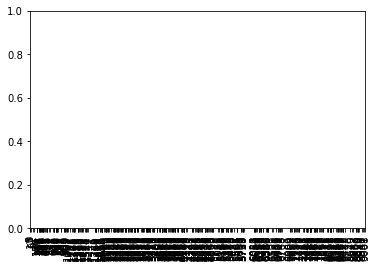

In [159]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion')]

df_subset['tweet'][0:50]

<ipython-input-169-a161d2ba87df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


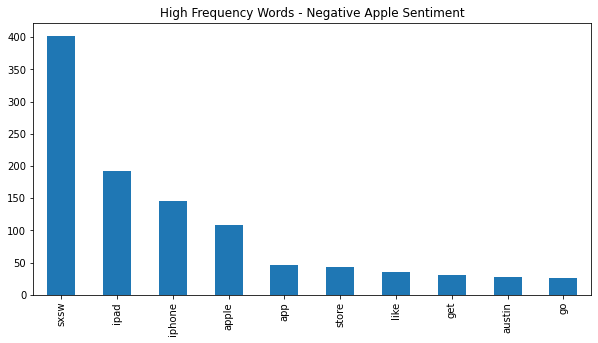

In [169]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
ax = df_subset.value_counts()[0:10].plot(kind='bar',
                                    title = 'High Frequency Words - Negative Apple Sentiment',
                                    figsize=(10,5))

<ipython-input-174-5cc04d99a2bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


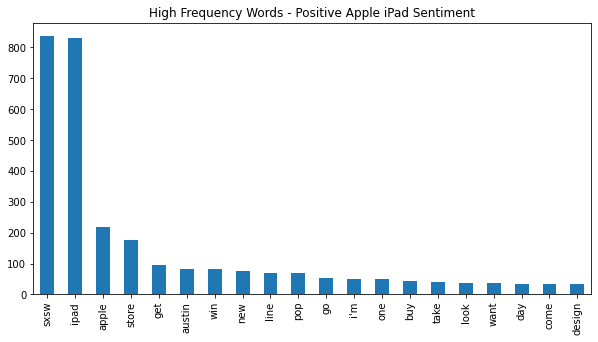

In [174]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Positive emotion')  & (df['product']=='iPad')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
ax = df_subset.value_counts()[0:20].plot(kind='bar',
                                    title = 'High Frequency Words - Positive Apple iPad Sentiment',
                                    figsize=(10,5))

<ipython-input-173-f83ff3d811d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


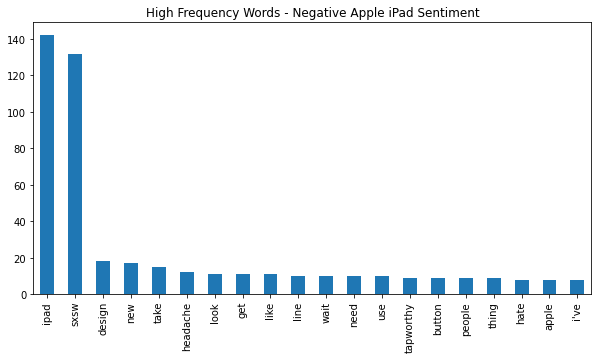

In [173]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion')  & (df['product']=='iPad')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
ax = df_subset.value_counts()[0:20].plot(kind='bar',
                                    title = 'High Frequency Words - Negative Apple iPad Sentiment',
                                    figsize=(10,5))

<ipython-input-170-13befb77b672>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


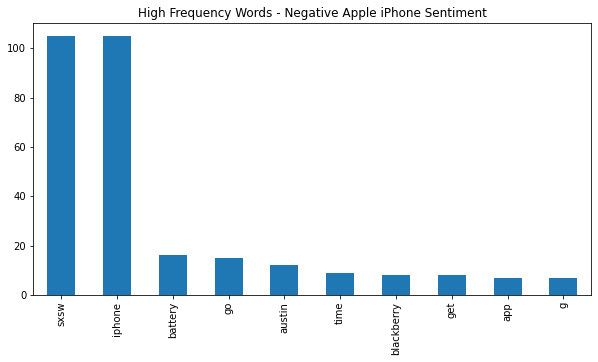

In [170]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion')  & (df['product']=='iPhone')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
ax = df_subset.value_counts()[0:10].plot(kind='bar',
                                    title = 'High Frequency Words - Negative Apple iPhone Sentiment',
                                    figsize=(10,5))

In [146]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion') & (df['product']=='iPhone')]

In [135]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion') & (df['product']=='iPhone') & (df['tweet_edited'].str.contains(''))]
df_subset['tweet'][0:50]

0       .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upg...
17      I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW co...
92      What !?!? @mention  #SXSW does not provide iPhone chargers?!?  I've changed my mind about going ...
233     If iPhone alarms botch the timechange, how many #SXSW'ers freak? Late to flights, missed panels,...
236                                                    I meant I also wish I  at #SXSW #dyac stupid iPhone!
324     Overheard at #sxsw interactive: &quot;Arg! I hate the iphone! I want my blackberry back&quot; #s...
335     overheard at MDW (and I'll second it) &quot;halfway through my iPhone battery already and I have...
357                      My iPhone battery can't keep up with my tweets! Thanks Apple.  #SXSW  #precommerce
421                                                   IPhone is dead. Find me on the secret batphone #sxsw.
541     Austin is getting fu

In [136]:
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion') & (df['product']=='iPhone') & (df['tweet_edited'].str.contains(''))]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset
df_subset.value_counts()[0:10]

<ipython-input-136-9dda880d72da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()


sxsw          105
iphone        105
battery        16
go             15
austin         12
time            9
blackberry      8
get             8
app             7
g               7
Name: tweet_edited, dtype: int64

In [137]:
df_apple_negative = df[(df['Company']=='Apple') & (df['sentiment']=='Positive emotion')]
df_apple_negative['tweet_edited'] = df_apple_negative['tweet_edited'].str.split()
df_apple_positive
df_apple_positive_words = df_apple_ipad_positive.tweet_edited.explode()
df_apple_positive_words
df_apple_positive_words.value_counts()[0:30]


<ipython-input-137-c3affceb7276>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple_negative['tweet_edited'] = df_apple_negative['tweet_edited'].str.split()


sxsw          189
iphone        186
get            25
ipad           21
amp            15
charge         14
use            14
make           14
new            13
i'm            13
love           13
case           12
phone          12
w              11
one             9
like            9
thanks          9
charger         9
free            9
android         9
next            9
give            8
battery         8
go              8
zazzlesxsw      8
ready           7
austin          7
sxswi           7
via             7
u               7
Name: tweet_edited, dtype: int64

In [138]:
df_apple_ipad_positive = df[(df['Company']=='Apple') & (df['product']=='iPad') & (df['sentiment']=='Positive emotion')]
df_apple_ipad_positive['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()
df_apple_ipad_positive
df_apple_ipad_positive_words = df_apple_ipad_positive.tweet_edited.explode()
df_apple_ipad_positive_words
df_apple_ipad_positive_words.value_counts()[0:30]




<ipython-input-138-c9141a3e92c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple_ipad_positive['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()


sxsw      838
ipad      829
apple     218
store     175
get        96
austin     83
win        82
new        75
line       69
pop        69
go         52
i'm        50
one        49
buy        44
take       40
look       36
want       36
day        34
come       34
design     34
sell       34
first      33
video      33
sxswi      32
like       31
need       30
open       30
wait       30
launch     29
via        29
Name: tweet_edited, dtype: int64

In [139]:
df_apple_ipad_positive = df[(df['Company']=='Apple') & (df['product']=='iPhone') & (df['sentiment']=='Positive emotion')]
df_apple_ipad_positive['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()
df_apple_ipad_positive
df_apple_ipad_positive_words = df_apple_ipad_positive.tweet_edited.explode()
df_apple_ipad_positive_words
df_apple_ipad_positive_words.value_counts()[0:30]

<ipython-input-139-6e53fd0d2be6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple_ipad_positive['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()


sxsw          189
iphone        186
get            25
ipad           21
make           14
use            14
charge         14
love           13
i'm            13
new            13
case           12
phone          12
w              11
charger         9
one             9
like            9
thanks          9
free            9
android         9
next            9
give            8
go              8
zazzlesxsw      8
battery         8
year            7
tell            7
austin          7
sxswi           7
via             7
u               7
Name: tweet_edited, dtype: int64

In [140]:
df_apple_iphone_negative = df[(df['Company']=='Apple') & (df['product']=='iPhone') & (df['sentiment']=='Negative emotion')]
df_apple_iphone_negative['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()
df_apple_iphone_negative
df_apple_iphone_negative_words = df_apple_ipad_positive.tweet_edited.explode()
df_apple_iphone_negative_words
df_apple_iphone_negative_words.value_counts()[0:30]


<ipython-input-140-c7bf4386ccb1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple_iphone_negative['tweet_edited'] = df_apple_ipad_positive['tweet_edited'].str.split()


sxsw          189
iphone        186
get            25
ipad           21
make           14
use            14
charge         14
love           13
i'm            13
new            13
case           12
phone          12
w              11
charger         9
one             9
like            9
thanks          9
free            9
android         9
next            9
give            8
go              8
zazzlesxsw      8
battery         8
year            7
tell            7
austin          7
sxswi           7
via             7
u               7
Name: tweet_edited, dtype: int64

In [141]:
tweet_words

2                                             can not wait for ipad also they should sale them down at sxsw
20      need to buy an ipad while i'm in austin at sxsw not sure if i'll need to q up at an austin apple...
25      rt i'm look forward to the smcdallas pre sxsw party wed and hop i'll win an ipad resulting from ...
36      the best rt ha first in line for ipad at sxsw quot pop up quot apple store be an event planner e...
57          link rt st stop on the sxsw chaos amp hunt austin java get in the spy game a chance win an ipad
                                                       ...                                                 
9063                       you should get the ipad to save your back from lug the laptop sxsw sxswmymistake
9070               you know you've make it to sxsw when you see a bunch of grown men hoot over get the ipad
9071                              what be your essential for sxsw mine pocket camera laptop ipad extra cord
9079                        